載入模組

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

讀取CSV檔

In [2]:
data = pd.read_csv("NPA_TMA1.csv") 
data[0:3]

,發生時間,發生地點,死亡受傷人數,車種,經度,緯度
0,110年01月01日 04時49分00秒,屏東縣萬巒鄉鹿寮村三多路1-8號前0.0公尺附近,死亡1;受傷0,普通重型-機車;自用-小貨車(含客、貨兩用),120.560111,22.567105
1,110年01月01日 04時57分00秒,臺中市霧峰區西柳橋頭,死亡1;受傷0,營業用-半聯結車;普通重型-機車,120.680001,24.070698
2,110年01月01日 07時30分00秒,南投縣仁愛鄉台8線 111公里100.0公尺處北側向外側,死亡1;受傷0,普通重型-機車;自用-小貨車(含客、貨兩用),121.303376,24.191833


移除Null(NA)

In [3]:
data = data.dropna()

分割日期與時間

In [4]:
data[['日期','時間']]  = data['發生時間'].str.split(' ', 1, expand=True)
data[['發生時間','日期','時間']][0:3]

,發生時間,日期,時間
0,110年01月01日 04時49分00秒,110年01月01日,04時49分00秒
1,110年01月01日 04時57分00秒,110年01月01日,04時57分00秒
2,110年01月01日 07時30分00秒,110年01月01日,07時30分00秒


分割死亡與受傷人數

In [5]:
data[['死亡人數','受傷人數']] = data['死亡受傷人數'].str.split(';', 1, expand=True).infer_objects()
data[['死亡受傷人數','死亡人數','受傷人數']][0:3]

,死亡受傷人數,死亡人數,受傷人數
0,死亡1;受傷0,死亡1,受傷0
1,死亡1;受傷0,死亡1,受傷0
2,死亡1;受傷0,死亡1,受傷0


將資料內“死亡”及“受傷”文字去除，並使用astype()轉換為int型態

In [6]:
data['死亡人數'] = data['死亡人數'].str.strip('死亡').astype(int)
data['受傷人數'] = data['受傷人數'].str.strip('受傷').astype(int)
data[['死亡人數','受傷人數']][0:3]

,死亡人數,受傷人數
0,1,0
1,1,0
2,1,0


擷取發生地縣市

In [7]:
data['縣市'] = data['發生地點'].str[0:3].astype(str)
data[['發生地點','縣市']][0:3]

,發生地點,縣市
0,屏東縣萬巒鄉鹿寮村三多路1-8號前0.0公尺附近,屏東縣
1,臺中市霧峰區西柳橋頭,臺中市
2,南投縣仁愛鄉台8線 111公里100.0公尺處北側向外側,南投縣


將整理後的資料擷取出來

In [8]:
people_count = data[['縣市','死亡人數','受傷人數']].copy()
people_count[0:10]

,縣市,死亡人數,受傷人數
0,屏東縣,1,0
1,臺中市,1,0
2,南投縣,1,0
3,臺中市,1,0
4,新北市,1,1
5,雲林縣,1,0
6,臺南市,2,2
7,苗栗縣,1,0
8,臺中市,1,0
9,嘉義縣,1,0


統計各縣市死亡及受傷人數

In [9]:
freq = people_count.groupby(['縣市']).sum()
freq[0:6]

,死亡人數,受傷人數
縣市,,
南投縣,11,2
嘉義市,1,1
嘉義縣,22,11
基隆市,3,2
宜蘭縣,25,50
屏東縣,33,18


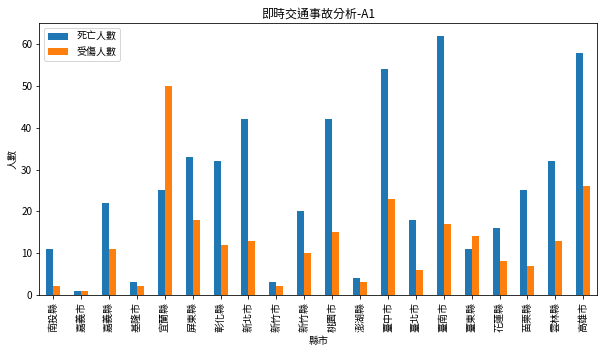

In [10]:
#設定中文字體
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']

chart = freq.plot(kind='bar',  #圖表類型
    title='即時交通事故分析-A1',  #圖表標題
    xlabel='縣市',  #x軸說明文字
    ylabel='人數',  #y軸說明文字
    legend=True,  # 是否顯示圖例
    figsize=(10, 5))  # 圖表大小
plt.show()